In [1]:
# author: Amine Abboudi
# importing requirements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# function to sample var values from a probability distribution
'''
    low: can be used as lower bound if dist=='unif' or first-order moment o.w.
    high: can be used as upper bound if dist=='unif' or second-order moment o.w.
'''

def sample_var(low=0., high=.5, dist='unif', n=1, seed=42):
    if dist=='unif':
        return np.random.uniform(low,high,n)
    if dist=='norm':
        return np.random.normal(low, high, n)
    else:
        return None
    
sample_var(dist='norm')

array([-0.17289872])

In [3]:
# function that returns the population from a dataframe by year
def get_population(X, year=2050):
    return int(X['population_'+str(year)].sum())

# function that returns the total production from a dataframe by year
def get_production(X, year=2050):
    return X['calories_'+str(year)].sum()

# function that calculates the caloric sufficiency. it is fed by a dataframe [to preserve generality]
def cal_suff(X, year=2050, food_waste=.19, diet=.19, feed_food_factor=2.3, pop_fact=1., ADER=2320*1e3*365.25):
    
    
    conso = 1-food_waste
    ratio = 1 + .52/.29
    perc_feed = conso / ratio
    perc_food = perc_feed * (ratio-1)
    
    prod = get_production(X, year=year)
    food = perc_food * prod
    feed_now_food = 0.
    LS = (1.1483e15*1e3) * get_population(X, year=2000) / 5976296907
    if year==2050:
        LS_2000 = LS
        LS = diet * (food + feed_food_factor * LS_2000) / (1 + diet * (feed_food_factor - 1))
        feed_now_food = feed_food_factor * (LS_2000 - LS)
    
    production = food + LS + feed_now_food
    demand = get_population(X, year) * pop_fact * ADER
    
    return production/demand


data_path = 'outputs/compare/'
df = pd.read_csv(data_path+'ssp1_compare_new.csv')

cal_suff(df, year=2000)

1.9568954104391354

In [137]:
# function that generates samples, calculates cal_suf for parametric variables ['food_waste', 'diet', 'feed_food_factor', 'pop_fact']
# returns  tuples of (sample, cal_suf)
# discriminates by year, ssp and country if need be

def sensitivity(random=False, var='food_waste', value=np.array([.5, .75, 1., 1.25, 1.5]), ssp=1, year=2050, country=None, **kwargs):
    
    data_path = 'outputs/compare/'
    df_ssp = pd.read_csv(data_path+'ssp'+str(ssp)+'_compare_new.csv')
    
    if country:
        df_ssp = df_ssp[df_ssp['ISO3']==country]

    if random:
        sample = sample_var(**kwargs)
        
    else:
        sample = value
    
    if var=='food_waste':
        sufficiency = cal_suff(df_ssp, year, food_waste=sample)
        
    if var=='diet':
        sufficiency = cal_suff(df_ssp, year, diet=sample)
        
    if var=='feed_food_factor':
        sufficiency = cal_suff(df_ssp, year, feed_food_factor=sample)
    
    if var=='pop_fact':
        sufficiency = cal_suff(df_ssp, year, pop_fact=sample)
        
    return sample, sufficiency

sensitivity(var='diet', ssp=5, country='MAR', n=1, dist='unif')

(array([0.5 , 0.75, 1.  , 1.25, 1.5 ]),
 array([0.70919753, 0.59249414, 0.50877214, 0.44578131, 0.39666981]))

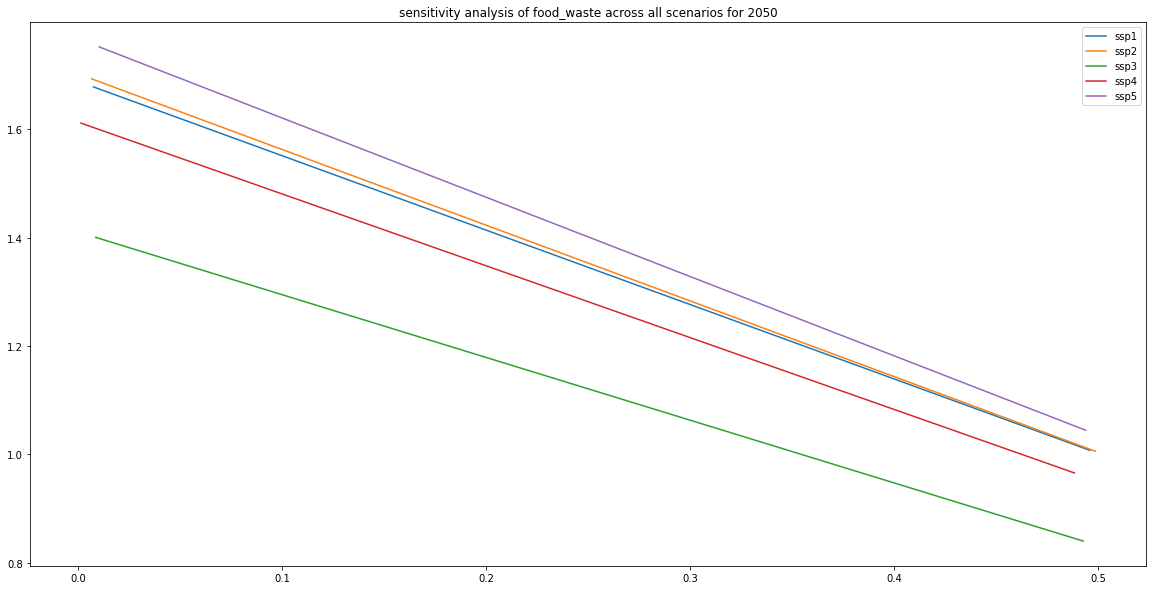

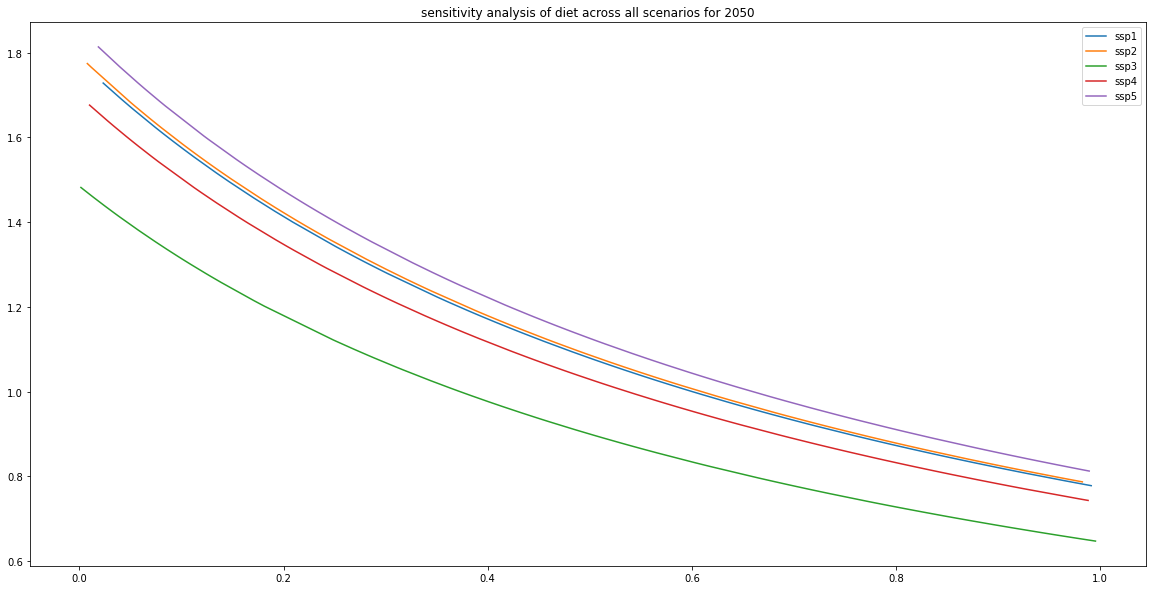

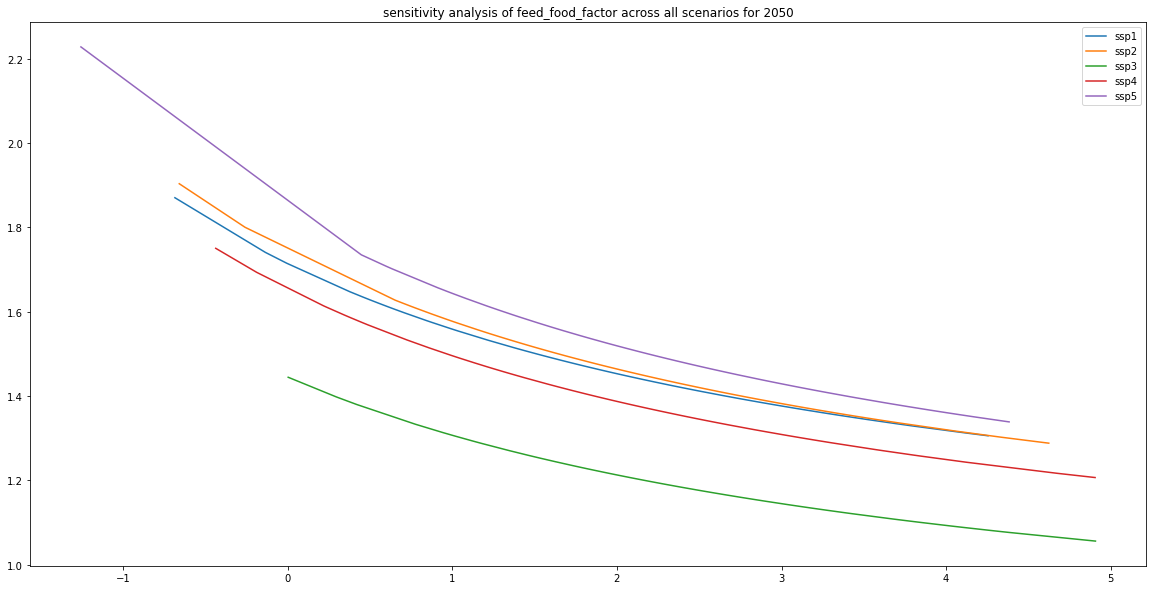

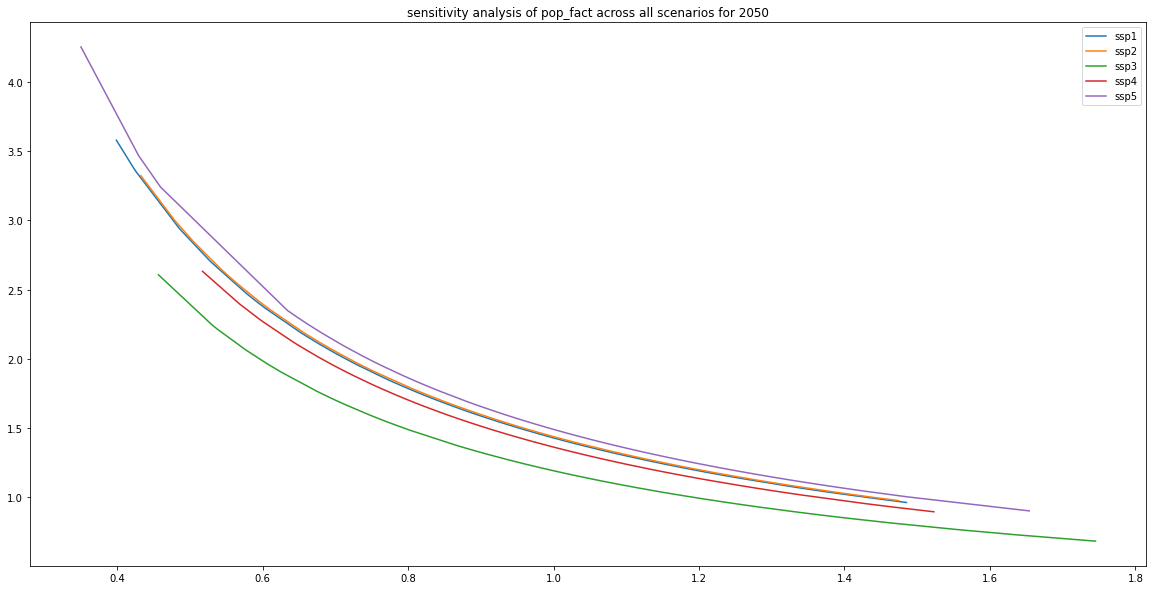

In [132]:
params = ['food_waste', 'diet', 'feed_food_factor', 'pop_fact']
lows = [0., 0., 2.3, 1.]
highs = [.5, 1., 1., .25]
dists = ['unif', 'unif', 'norm', 'norm']
year=2050

for param, low, high, dist in zip(params, lows, highs, dists):
    plt.figure(figsize=(20,10))
    
    for i in range(5):
        x, y = sensitivity(var=param, ssp=i+1, year=year, country=None,n=100, dist=dist, low=low, high=high)

        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        plt.plot(x, y, label='ssp'+str(i+1))
        plt.legend()

    plt.title('sensitivity analysis of '+param+' across all scenarios for '+str(year))
    plt.show()

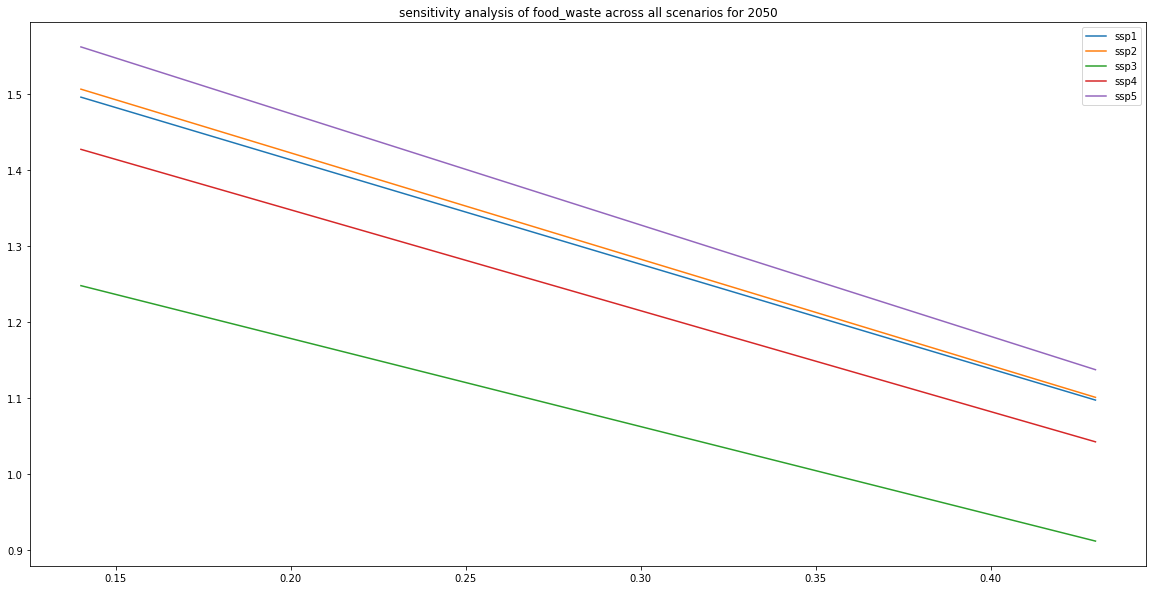

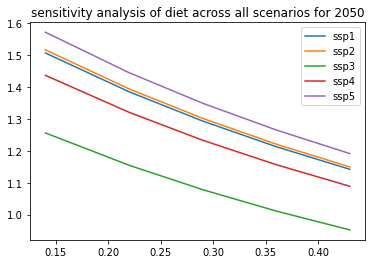

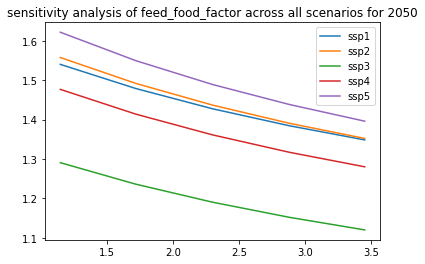

In [138]:
params = ['food_waste', 'diet', 'feed_food_factor']
lows = [0., 0., 2.3]
highs = [.5, 1., 1.]
dists = ['unif', 'unif', 'norm']
year=2050

cols = [
    'value',
    'ssp1_global',
    'ssp2_global',
    'ssp3_global',
    'ssp4_global',
    'ssp5_global',
]

values = [
    np.round(.29 * np.array([.5, .75, 1., 1.25, 1.5]), 2),
    np.round(.29 * np.array([.5, .75, 1., 1.25, 1.5]), 2),
    np.round(2.3 * np.array([.5, .75, 1., 1.25, 1.5]), 2),
    
]

df_global = pd.DataFrame(columns=cols)

for s, param in enumerate(params):
    plt.figure(figsize=(20,10))
    for i in range(5):
        x, y = sensitivity(var=param, ssp=i+1, year=year, country=None,n=1000, value=values[s])
        df_global.loc[:, 'value'] = x
        df_global.loc[:, 'ssp'+str(i+1)+'_global'] = y
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        plt.plot(x, y, label='ssp'+str(i+1))
        plt.legend()
        
    df_global.to_csv('sa_glo_'+param+'_new.csv', index=False)

    plt.title('sensitivity analysis of '+param+' across all scenarios for '+str(year))
    plt.show()

In [150]:
# function that generates samples, calculates cal_suf for predicted values ['cropland', 'yield']
# returns  tuples of (sample, cal_suf)
# discriminates by year, ssp and country if need be

def sensitivity_2(random=False, var='cropland', ssp=1, year=2050, country=None, **kwargs):
    var_dict = {'cropland': '%cropland_2050', 'yield':'cal_per_ha_pred', 'population':'population_2050'}
    sufficiency = []
    
    data_path = 'outputs/compare/'
    df_ssp = pd.read_csv(data_path+'ssp'+str(ssp)+'_compare_new.csv')
    
    if random:
        sample = sample_var(**kwargs)
        
    else:
        sample = np.array([.5, .75, 1., 1.25, 1.5])
    
    if country:
        df_ssp = df_ssp[df_ssp['ISO3']==country]
        
    df_dup = df_ssp.copy()
#     sample = sample_var(**kwargs)
    for smp in list(sample):
        if var=='population':
            sufficiency.append(cal_suff(df_dup, pop_fact=smp))
        else:
            df_dup[var_dict[var]] = df_ssp[var_dict[var]]*smp
            df_dup['calories_2050'] = df_dup['%cropland_2050'] * df_dup['cal_per_ha_pred'] * df_dup['ha_per_pixel']
            sufficiency.append(cal_suff(df_dup))
    if var=='population':
        return ((sample * df_ssp[var_dict[var]].sum())), np.array(sufficiency)
    else:
        return ((sample * df_ssp[var_dict[var]].mean()) - (df_ssp[var_dict[var][:-4]+'2000'].mean())), np.array(sufficiency)

sensitivity_2(var='yield', ssp=5, country='USA', n=1, low=1., high=.02, dist='norm')

(array([-7.57060863e+09, -5.36051953e+09, -3.15043044e+09, -9.40341340e+08,
         1.26974776e+09]),
 array([1.11545622, 1.56694418, 2.01843214, 2.4699201 , 2.92140806]))

<Figure size 1440x720 with 0 Axes>

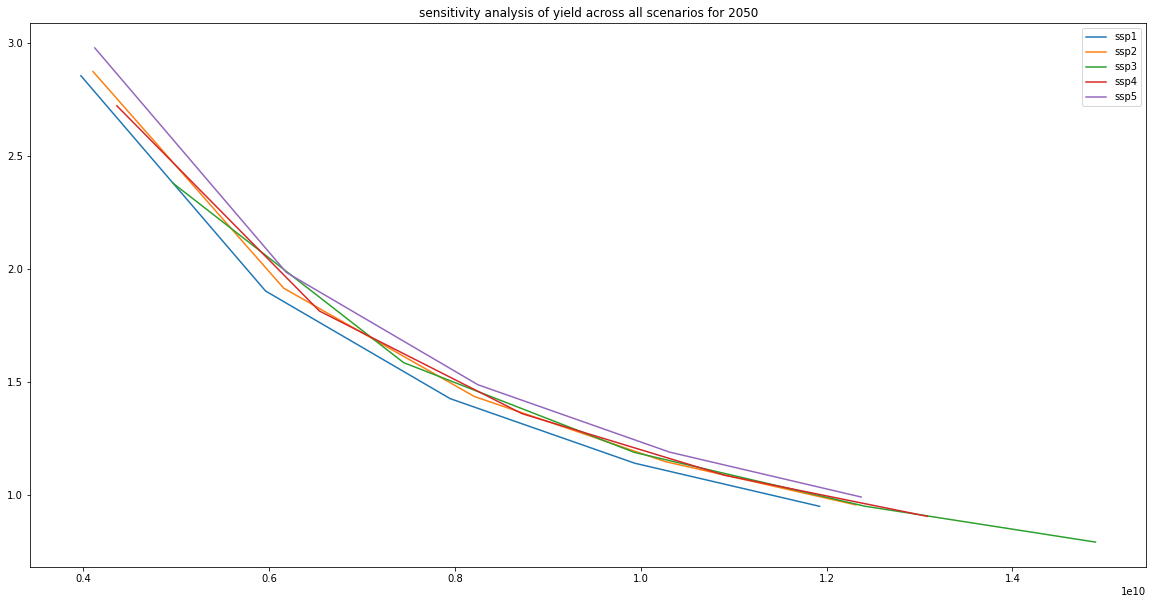

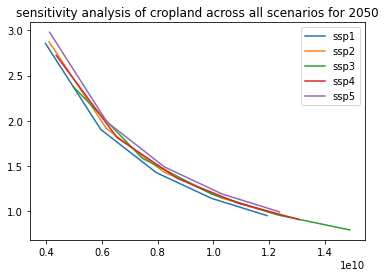

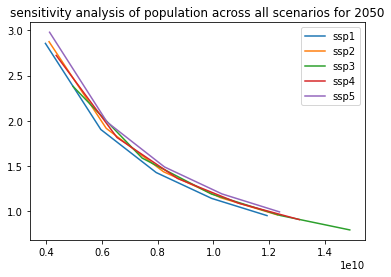

In [152]:
plt.figure(figsize=(20,10))

params = ['yield', 'cropland', 'population']

year=2050

cols = [
    'value',
    'ssp1_global',
    'ssp2_global',
    'ssp3_global',
    'ssp4_global',
    'ssp5_global',
]


# for param, low, high, dist in zip(params, lows, highs, dists):
for param in params:
    plt.figure(figsize=(20,10))
    df_global = pd.DataFrame(columns=cols)
    for i in range(5):
        x, y = sensitivity_2(var='population', ssp=i+1)
        to_stack = pd.DataFrame(np.array([x,y]).T, columns=['value', 'ssp'+str(i+1)+'_global'])
        df_global = pd.concat([df_global, to_stack])
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        plt.plot(x, y, label='ssp'+str(i+1))
        plt.legend()

    plt.title('sensitivity analysis of '+param+' across all scenarios for '+str(year))
    plt.show()
    df_global.sort_values(by='value').interpolate().to_csv('sa_glo_'+param+'.csv', index=False)

In [126]:
df_cat = pd.read_csv('sa_pop_fact2.csv')
df_out = pd.DataFrame(columns=df_cat.columns)
df_out['value'] = df_global['value'].copy()
categ_cols = ['value', 'ssp1_Decreasing but not as vulnerable',
 'ssp1_Exporters',
 'ssp1_Highly variable',
 'ssp1_Importers',
 'ssp1_Increasing sufficiency',
 'ssp1_Most vulnerable',
 'ssp1_Newly vulnerable',
 'ssp1_Vulnerable but improving',
 'ssp2_Decreasing but not as vulnerable',
 'ssp2_Exporters',
 'ssp2_Highly variable',
 'ssp2_Importers',
 'ssp2_Increasing sufficiency',
 'ssp2_Most vulnerable',
 'ssp2_Newly vulnerable',
 'ssp2_Vulnerable but improving',
 'ssp3_Decreasing but not as vulnerable',
 'ssp3_Exporters',
 'ssp3_Highly variable',
 'ssp3_Importers',
 'ssp3_Increasing sufficiency',
 'ssp3_Most vulnerable',
 'ssp3_Newly vulnerable',
 'ssp3_Vulnerable but improving',
 'ssp4_Decreasing but not as vulnerable',
 'ssp4_Exporters',
 'ssp4_Highly variable',
 'ssp4_Importers',
 'ssp4_Increasing sufficiency',
 'ssp4_Most vulnerable',
 'ssp4_Newly vulnerable',
 'ssp4_Vulnerable but improving',
 'ssp5_Decreasing but not as vulnerable',
 'ssp5_Exporters',
 'ssp5_Highly variable',
 'ssp5_Importers',
 'ssp5_Increasing sufficiency',
 'ssp5_Most vulnerable',
 'ssp5_Newly vulnerable',
 'ssp5_Vulnerable but improving']

for i in range(5):
    for (j,col) in enumerate(categ_cols):
        if col[:4] == 'ssp'+str(i+1):
            df_out.iloc[(5*i):(5*(i+1)), j] = df_cat[col]

for col in df_out.columns:
    df_out[col] = df_out[col].astype('float')
    
df_out.sort_values(by='value').interpolate().to_csv('inter_population_out.csv')